# Spherical-Spheroidal Inner-Products
<center> Validate understanding of LAL/NR conventions by testing inner-products between Spherical and Spheroidal harmonic functions (within LAL) </center>

#### Notes:
 * 13/9/2017: To fix the note below, convergence within the LAL Spheroidal harmonic function was constrained to be monotonic. This results in accurate behavior with the exception of l=m=5 for which there is a sharp feature near extremal spin. There may be another more effective fix, such as reconsidering how the QNM data is interpolated -- adding more points??
 * 13/9/2017: Some LAL Spheroidal modes produce NANs for very high spins. This likely results from imprecisions in the interpolation of QNM parameters (ferqs, sep consts) in this regime -- note that these imprecissions are fractions of fractions of a percent! D: ... A method for computing spheroidal harmonics without while-loops would be nice ...
 * 13/9/2017: Inner-proucts largely consistent between LAL and Python calculation, with l=m=5 not quite consistent. Is this due to normalization fit for l=m=5? Yes.
 * 13/9/2017: Implementation of LAL function to compute inner product between spherical and spheroidal harmonic fucntions.
 * 12/9/2017: Conventions of LAL Spheroidal harmonic funtoin agree with LAL spherical harmonic function when jf=0.

## Setup Environment

In [10]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm,ysprod,ssprod
from kerr.models import mmrdns as ns
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
plotdir = '/Users/book/KOALA/review_ringdownFD_nikhef/gallery/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Plot LAL Spherical Harmonic and LAL Spheroidal Harmonic for jf=0
They should be the same for an array of (l,m) values.

#### Generate Spherical Harmonics from standard LAL sunction, and from LAL Spheroidal function

In [11]:
#
theta = linspace(0,pi,256)
phi = pi/3
s,n = -2,0

#
lmlist = []
for l,m in [ (2,2), (2,1), (3,3), (3,2), (4,4), (4,3), (5,5) ]:
    lmlist += [(l,m)]; lmlist += [(l,-m)]
lmlist = sorted(lmlist,key = lambda K: -sign(K[-1]) )
    
#
Y1 = {}; Y2 = {}
for l,m in lmlist:
    print l,m
    Y1[l,m] = array([ lal.SpinWeightedSphericalHarmonic( th, phi, s, l, m ) for th in theta ])
    Y2[l,m] = array([ lalsim.SpinWeightedSpheroidalHarmonic( 0, l, m, n, th, phi ) for th in theta ])

2 2
2 1
3 3
3 2
4 4
4 3
5 5
2 -2
2 -1
3 -3
3 -2
4 -4
4 -3
5 -5


#### Plot Amplitudes

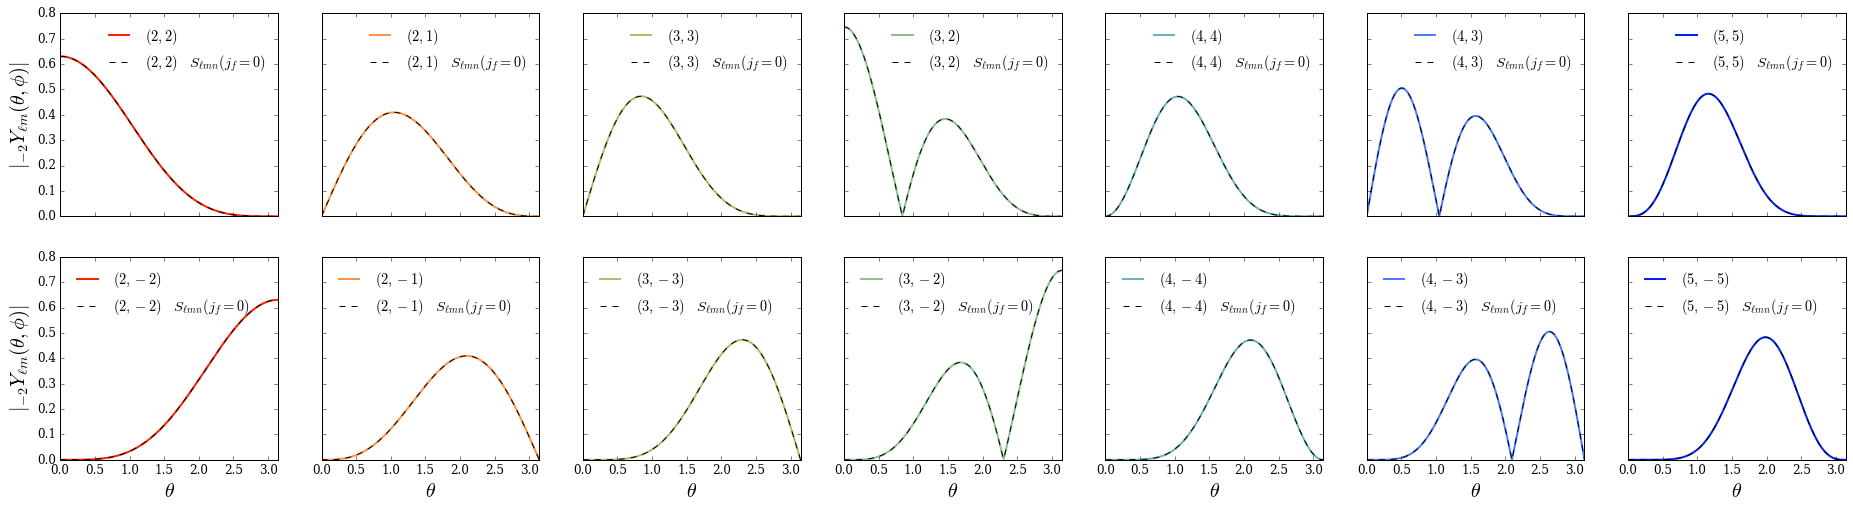

In [12]:
#
w = int(len(lmlist)/2)
fig,ax = subplots(2,w,sharex=True,sharey=True,figsize=4*array([w+1,2]))
ax = ax.flatten(); clr = rgb(w,jet=True)

# Amplitude
for j, (a,k) in enumerate( zip(ax,lmlist) ):
    sca(a)
    if j+1>w: xlabel(r'$\theta$')
    if (j==0) or (j==w): ylabel(r'$|_{-2}Y_{\ell m}(\theta,\phi)|$' )
    plot( theta, abs(Y1[k]), label='$%s$'%str(k), color=clr[ mod(j,w) ], linewidth=2 )
    plot( theta, abs(Y2[k]), label=r'$%s \quad S_{\ell m n}(j_f = 0)$'%(str(k)), color=0*clr[ mod(j,w) ], linewidth=1, linestyle='--' )
    xlim( lim(theta) ); legend( frameon=False, loc = 1 if k[-1]>0 else 2 )
    
# Save figure
figpath = plotdir+'issue_2_harmonic_amplitudes.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

#### Plot Phases
NOTE that disagreements should either be close to zero, or approximately $2\pi$.

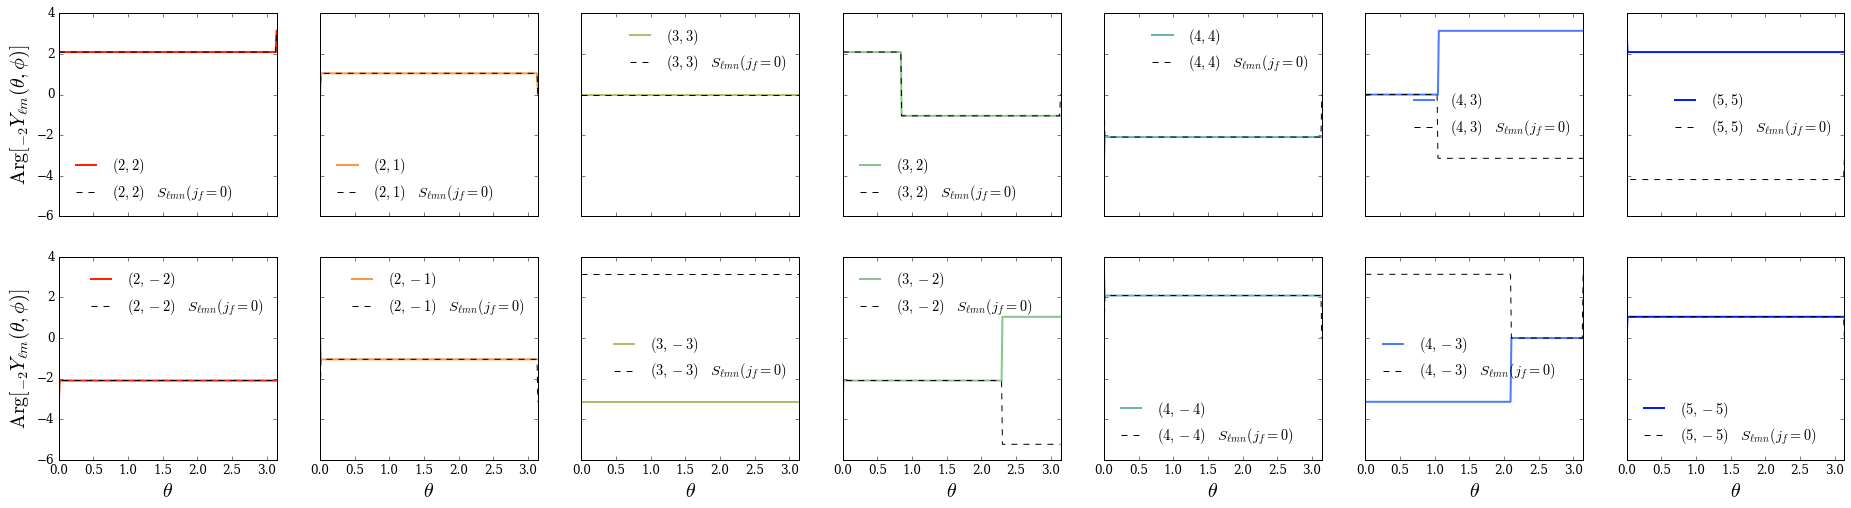

In [4]:
#
w = int(len(lmlist)/2)
fig,ax = subplots(2,w,sharex=True,sharey=True,figsize=4*array([w+1,2]))
ax = ax.flatten(); clr = rgb(w,jet=True)

#
arg = lambda X: unwrap(angle(X))

# Amplitude
for j, (a,k) in enumerate( zip(ax,lmlist) ):
    sca(a)
    if j+1>w: xlabel(r'$\theta$')
    if (j==0) or (j==w): ylabel(r'$\mathrm{Arg}[_{-2}Y_{\ell m}(\theta,\phi)]$' )
    plot( theta,arg(Y1[k]), label='$%s$'%str(k), color=clr[ mod(j,w) ], linewidth=2 )
    plot( theta, arg(Y2[k]), label=r'$%s \quad S_{\ell m n}(j_f = 0)$'%(str(k)), color=0*clr[ mod(j,w) ], linewidth=1, linestyle='--' )
    xlim( lim(theta) ); legend( frameon=False, loc ='best' )
    
# Save figure
figpath = plotdir+'issue_2_harmonic_phases.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

#### Do they Co-Normalize?

In [5]:
#
for k in lmlist:
    P = 2*pi*trapz(Y1[k]*conj(Y2[k])*sin(theta),theta)
    print '>> %s\t:\t%e\t+\t1j*%e'%(k,P.real,P.imag)

>> (2, 2)	:	9.999487e-01	+	1j*-1.399866e-12
>> (2, 1)	:	1.000188e+00	+	1j*-4.502245e-13
>> (3, 3)	:	1.000045e+00	+	1j*-7.696537e-13
>> (3, 2)	:	1.000417e+00	+	1j*2.042486e-13
>> (4, 4)	:	1.000161e+00	+	1j*-2.746097e-14
>> (4, 3)	:	1.000702e+00	+	1j*1.301408e-13
>> (5, 5)	:	1.000444e+00	+	1j*3.053041e-13
>> (2, -2)	:	9.999487e-01	+	1j*1.399162e-12
>> (2, -1)	:	1.000188e+00	+	1j*4.498256e-13
>> (3, -3)	:	1.000045e+00	+	1j*7.692863e-13
>> (3, -2)	:	1.000417e+00	+	1j*-2.049482e-13
>> (4, -4)	:	1.000161e+00	+	1j*2.617037e-14
>> (4, -3)	:	1.000702e+00	+	1j*-1.305084e-13
>> (5, -5)	:	1.000444e+00	+	1j*-3.076412e-13


## Compare Local, Python and LAL methods for Inner Product calculation

#### Spot check

In [6]:
# BH Spin
jf = 0.88
# Spherical indeces
ll,mm = 3,2
# Spheroidal indeces
l,m,n = 2,mm,0
# Number of points in theta to use
N = 512
phi=0

# Manual in notebook check of integral
dth = pi/N
th = ans = 0
for k in range(1,N):
    th += dth
    ans += 2*pi*dth*lal.SpinWeightedSphericalHarmonic( th, phi, s, ll, mm  ) * lalsim.SpinWeightedSpheroidalHarmonic( jf, l, m, n, th, phi ) * sin(th)

# Compare the notebook's check above to LAL and python versions of the calculation
print lalsim.SphericalSpheroidalInnerProduct(jf,ll,mm,l,m,n,N), ysprod(jf,ll,mm,(l,m,n),N), ans

(0.10713298666-0.0124885140014j) (0.107138146751-0.0124891155021j) (0.107133027873-0.0124885151054j)


## Compute Inner-Products for an array of multipoles

#### Generate select inner product values

In [7]:
#
jfrange = linspace(0,0.99,30)

#
jklist = { (2,2):[(2,2,0),(2,2,0),(3,2,0)],
           (3,3):[(3,3,0),(3,3,1),(4,3,0)],
           (3,2):[(3,2,0),(2,2,0)],
           (4,4):[(4,4,0)],
           (5,5):[(5,5,0)] }

#
h = 0
jkmap = {}; P = []; Q = []
for j in jklist:
    for k in jklist[j]:
        jkmap[h] = [ j,k ]
        ll,mm = j; l,m,n = k
        P.append( array( [ lalsim.SphericalSpheroidalInnerProduct(jf,ll,mm,l,m,n,N) for jf in jfrange ] ) )
        Q.append( array( [ ysprod(jf,ll,mm,(l,m,n),N) for jf in jfrange ] ) )
        h += 1
#
if mod(len(P),2): 
    P.append( zeros_like(jfrange) )
    Q.append( zeros_like(jfrange) )
    jkmap[h] = ''

#### Plot inner product values

2.41770556864
0.962664683398
0.159705117904
0.974077888548
0.978382953973
0.978124146059
0.22440040584
0.987088202566
0.987088202566
0.183102159441


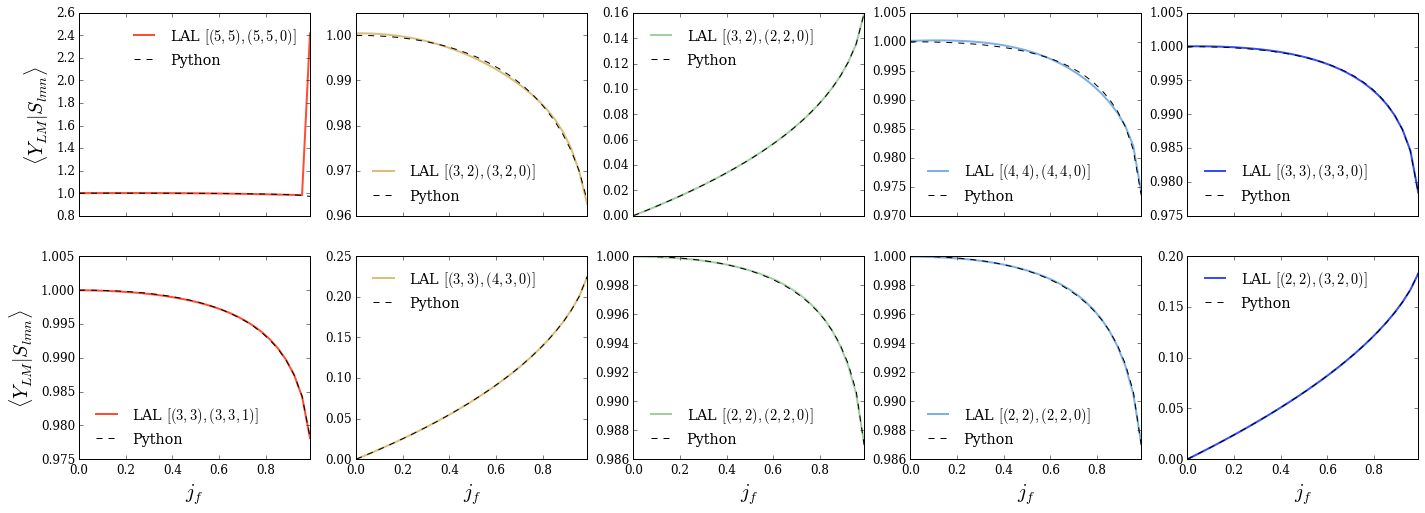

In [8]:
#
w = int(len(P)/2)
fig,ax = subplots(2,w,sharex=True,sharey=not True,figsize=4*array([w+1,2]))
ax = ax.flatten(); clr = rgb(w,jet=True)

# Amplitude
for h, (a,p,q) in enumerate(zip(ax,P,Q)):
    sca(a)
    if h+1>w: xlabel(r'$j_f$')
    if (h==0) or (h==w): ylabel(r'$ \langle Y_{LM} | S_{lmn} \rangle $' )
    plot( jfrange, abs(p), label='LAL $%s$'%str(jkmap[h]), color=clr[ mod(h,w) ], linewidth=2, alpha=0.8 )
    plot( jfrange, abs(q), label='Python', color=0*clr[ mod(h,w) ], linewidth=1, linestyle='--' )
    xlim( lim(jfrange) ); legend( frameon=False, loc =0 )
    print abs(p)[-1]
    
# Save figure
figpath = plotdir+'issue_2_inner_products.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

#### Test normalization of LAL Spheroidal harmonics

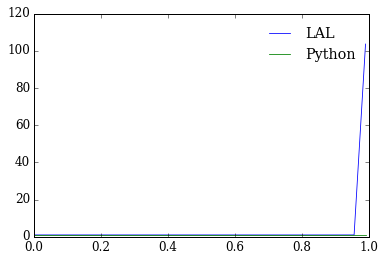

In [9]:
l1,m1,n1 = 5,5,0
l2,m2,n2 = 5,5,0
theta = linspace(0,pi,256)
SP = array([ lalsim.SpheroidalSpheroidalInnerProduct( jf, l1,m1,n1,l2,m2,n2, 512 ) for jf in jfrange ])
sp = array( [ trapz( 2*pi*sin(theta)*slm(jf,l1,m1,n1,theta,0)*conj(slm(jf,l2,m2,n2,theta,0)), x=theta ) for jf in jfrange ] )
jfrange = linspace(0,0.99,30)
plot( jfrange, abs(SP), label='LAL' )
plot( jfrange, abs(sp), label='Python' )
legend( frameon=False, loc='best' )